In [101]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from collections import namedtuple
import copy

import awkward as ak
import uproot
import matplotlib
import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np
import pandas as pd
from rich import print

from particle import Particle

from python.analysis import Master, Plots, cross_section, vector

def hist_glow(alpha = 0.03, n = 5, width = 1.05):
    ax = plt.gca()
    for patch in ax.get_children()[:-1]: # last patch in children is the grid
        if type(patch) not in [matplotlib.patches.Polygon, matplotlib.patches.Rectangle]: continue # only add glow to histogram patches
        for i in range(1, n + 1):
            new_patch = copy.copy(patch)

            if new_patch.get_edgecolor() == (0, 0, 0, 0):
                edgecolor = new_patch.get_facecolor()
            else:
                edgecolor = new_patch.get_edgecolor()

            new_patch.set(alpha = alpha, linewidth = new_patch.get_linewidth() + (width * i), edgecolor = edgecolor, facecolor = new_patch.get_facecolor(), zorder = 0.6) # grid lines are hardcoded at zorder 0.5
            ax.add_patch(new_patch)


class ThinSlice():

    def __init__(self, v : ak.Array, vmin : float, vmax : float, slice_width : float) -> None:
        self.slice_width = slice_width
        self.slices = ThinSlice.CreateThinSlices(vmin, vmax, self.slice_width)
        self.slice_masks = ThinSlice.SliceMasks(v, self.slices)
        self.n_incident = ThinSlice.Incident(self.slice_masks, self.slices)
        pass

    Slice = namedtuple("Slice", "num pos")

    class Slices(list):
        def __init__(self, width):
            self.width = width

        def __setitem__(self, __index, __value):
            if isinstance(__value, ThinSlice.Slice):
                super().__setitem__(__index, __value)
            else:
                raise TypeError(f"Only {ThinSlice.Slice.__name__} can be added to Slices.")

        def append(self, __value):
            if isinstance(__value, ThinSlice.Slice):
                super().append(__value)
            else:
                raise TypeError(f"Only {ThinSlice.Slice.__name__} can be added to Slices.")

        def insert(self, __index, __value) -> None:
            if isinstance(__value, ThinSlice.Slice):
                super().insert(__index, __value)
            else:
                raise TypeError(f"Only {ThinSlice.Slice.__name__} can be added to Slices.")

        def extend(self, __value) -> None:
            if isinstance(__value, ThinSlice.Slice):
                super().extend(__value)
            else:
                raise TypeError(f"Only Slices can be combined to Slices")

        @property
        def num(self):
            return np.array([ s.num for s in self], dtype = int)

        @property
        def pos(self):
            return np.array([ s.pos for s in self])
        
        
        def pos_to_num(self, pos):
            slice_num = np.floor(pos//self.width)
            if hasattr(pos, "__iter__"):
                slice_num = ak.values_astype(slice_num, int)
                slice_num = ak.where(pos > max(self.pos), max(self.num), slice_num)
                slice_num = ak.where(pos < 0, min(self.num), slice_num)
            else:
                slice_num = int(slice_num)
                if pos > max(self.pos): 
                    slice_num = max(self.num) # above range go into overflow bin
                if pos < 0:
                    slice_num = min(self.num) # below range go into the upstream loss bin
            return slice_num


        def apply_func(self, func : callable, pos, value = None) -> np.array:
            slice_num = self.pos_to_num(pos)
            val = np.zeros(len(self), dtype = float)
            
            if value is None:
                value = pos

            for s in self.num:
                val[s + 1] = func(value[slice_num == s])
            return val


        def mean(self, pos : ak.Array, value : ak.Array):
            return self.apply_func(ak.mean, pos, value)


        def std(self, pos : ak.Array, value : ak.Array):
            return self.apply_func(ak.std, pos, value)


        def count(self, pos : ak.Array):
            return self.apply_func(ak.count, pos, value = None) # to count entries we only need the position


    @staticmethod
    def CreateThinSlices(min, max, width):
        slices = ThinSlice.Slices(width)


        for i in np.arange(min - (1 * width), max + (2 * width), width):
            slices.append(ThinSlice.Slice(int(i//width), i))
        return slices

    @staticmethod
    def SliceMasks(z : ak.Array, slices : Slices):
        end_slices = slices.pos_to_num(z)

        slice_masks = [] # mask per slice indicating whether a particle stopped within the slice
        for s in slices.num:
            slice_masks.append(end_slices == s)

        return slice_masks

    @staticmethod
    def Incident(slice_masks : list, slices : Slices):
        n_incident = [] # n_incident can be calculated based on the cumulative sum done in reverse order (assuming particle at slice n must have travelled through all prior slices)
        for i, s in enumerate(slices):

            n_incident.append( sum( sum(slice_masks[i:]) ) )

        return np.array(n_incident, dtype = int)

    @staticmethod
    def CountingExperiment(slice_masks : list, region : ak.Array):
        n_interact = []
        for s in slice_masks:
            n_interact.append(sum(s & region))

        return np.array(n_interact, dtype = int)

    @staticmethod 
    def CrossSection(n_incident : np.array, n_interact : np.array, slice_width : float):
        xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section

        # xs_e = 1/(n_incident - n_interact) * ((n_interact**2/n_incident) + n_interact)**0.5

        v_incident = n_incident # poisson uncertainty
        v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty

        xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5

        NA = 6.02214076e23
        factor = 10**27 * cross_section.BetheBloch.A  / (cross_section.BetheBloch.rho * NA * slice_width)

        return factor * xs, abs(factor * xs_e)

    @staticmethod
    def MeanSliceEnergy(slices : Slices, z : ak.Array, energy : ak.Array):
        return slices.mean(z, energy)

class CrossSections:
    labels = {"abs_KE;1" : "absorption", "inel_KE;1" : "quasielastic", "cex_KE;1" : "charge_exchange", "dcex_KE;1" : "double_charge_exchange", "prod_KE;1" : "pion_production", "total_inel_KE;1" : "total_inelastic"}

    def __init__(self, file : str) -> None:
        self.file = uproot.open(file)

        for k in self.file.keys():
            if "KE" in k:
                g = self.file[k]
                setattr(self, self.labels[k], g.all_members["fY"])
        self.KE = self.file["abs_KE;1"].all_members["fX"]
        pass

    def __PlotAll(self):
        for k in self.labels.values():
            Plots.Plot(self.KE, getattr(self, k)[0:len(self.KE)], label = k.replace("_", " "), newFigure = False, xlabel = "KE (MeV)", ylabel = "$\sigma (mb)$")

    def Plot(self, xs : str):
        if xs == "all":
            self.__PlotAll()
        else:
            Plots.Plot(self.KE, getattr(self, xs)[0:len(self.KE)], label = xs.replace("_", " "), newFigure = False, xlabel = "KE (MeV)", ylabel = "$\sigma (mb)$")


def truth_regions(events):
    inelastic = events.trueParticles.true_beam_endProcess == "pi+Inelastic"
    absorption = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 0)
    cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 1)
    quasielastic = (events.trueParticles.nPiPlus == 1) & (events.trueParticles.nPi0 == 0)
    return {"total_inelastic" : inelastic, "absorption" : absorption, "charge_exchange" : cex, "quasielastic" : quasielastic}


def EsliceDemo(events, e_min : float = 50, e_max : float = 1050, e_width : float = 50):
    cross_sections = CrossSections("test/g4_xs.root")
    energy_slices = ThinSlice.CreateThinSlices(e_min, e_max, e_width)
    mean_dEdX = cross_section.BetheBloch.meandEdX(energy_slices.pos, Particle.from_pdgid(211))

    slice_masks = ThinSlice.SliceMasks(events.trueParticles.beam_traj_KE[:, -2], energy_slices)

    # n_incident = ThinSlice.Incident(slice_masks[::-1], energy_slices)
    # n_incident = n_incident[::-1]

    first_in_tpc = ak.argmax(events.trueParticles.beam_traj_pos.z > 0, axis = 1, keepdims = True)
    first_KE = ak.flatten(events.trueParticles.beam_traj_KE[first_in_tpc])
    first_slice = energy_slices.pos_to_num(first_KE)
    end_slice = energy_slices.pos_to_num(events.trueParticles.beam_traj_KE[:, -2])
    print(first_slice)
    print(end_slice)

    n_incident = np.zeros(len(energy_slices), dtype = int)
    for f, e in zip(first_slice, end_slice):
        n_incident[e : f+1] += 1

    print(n_incident)

    regions = truth_regions(events)
    for i, region in Plots.IterMultiPlot(regions):
        print(f"evaluating {region} region")
        n_interact = ThinSlice.CountingExperiment(slice_masks, regions[region])
        xs = ThinSlice.CrossSection(n_incident, n_interact, energy_slices.width/mean_dEdX)
        cross_sections.Plot(region)
        Plots.Plot(energy_slices.pos[1:-1], xs[0][1:-1], yerr = xs[1][1:-1], xerr = 25, marker = "x", linestyle = "", newFigure = False, label = "MC truth", xlabel = "KE (MeV)", ylabel = "$\sigma$(mb)")
        plt.xlim(0, 1500)


def ThinSliceDemo(events):
    cross_sections = CrossSections("test/g4_xs.root")
    ts = ThinSlice(events.trueParticles.beam_traj_pos.z[:, -1], 0, 230, 10)
    print("n_incident calculated")
    mean_slice_energy = ThinSlice.MeanSliceEnergy(ts.slices, events.trueParticles.beam_traj_pos.z[:, :-1], events.trueParticles.true_beam_traj_KE[:, :-1])
    mean_error_slice_energy = ts.slices.std(events.trueParticles.beam_traj_pos.z[:, :-1], events.trueParticles.true_beam_traj_KE[:, :-1]) / np.sqrt(ts.slices.count(events.trueParticles.beam_traj_pos.z[:, :-1]))
    print("mean energy of slice calculated")

    regions = truth_regions(events)
    for i, region in Plots.IterMultiPlot(regions):
        print(f"evaluating {region} region")
        n_interact = ts.CountingExperiment(ts.slice_masks, regions[region])
        xs = ThinSlice.CrossSection(ts.n_incident, n_interact, 10)
        cross_sections.Plot(region)
        Plots.Plot(mean_slice_energy[1:-1], xs[0][1:-1], yerr = xs[1][1:-1], xerr = mean_error_slice_energy[1:-1], xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = "MC truth")
        plt.xlim(0, 1500)


cross_section.SetPlotStyle(dpi = 140)
# plt.style.use("cyberpunk")
# plt.rcParams["figure.dpi"] = 140

#TODO Fix Geant4 simulations so kinetic energy range is 0, 4000
#TODO add error for energy bins
#TODO check what traj_KE actually is and how is it calculated
#? rework mean kinetic energy to estimate the kinetic energy at the start of the thin slice?


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(0.0, 2000.0)

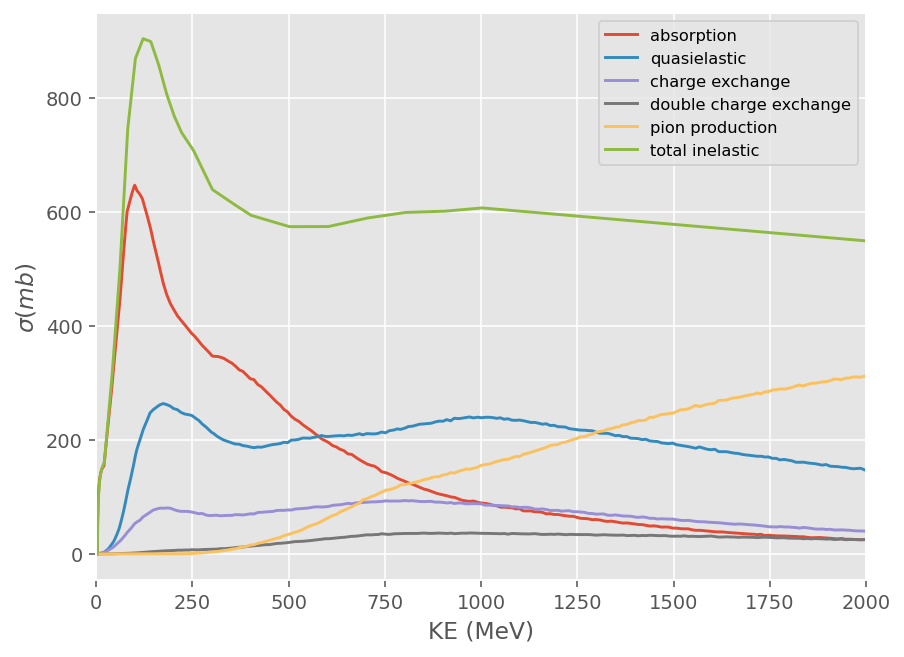

In [16]:
cross_sections = CrossSections("test/g4_xs.root")
cross_sections.Plot("all")
plt.xlim(0, 2000)
# mplcyberpunk.add_glow_effects()


In [3]:
events = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", nTuple_type = Master.Ntuple_Type.PDSP)

def AddVariable(name : str, target : Master.ParticleData):
    target.LoadData(name, name)
    setattr(target, name, getattr(target, f"_{target.__class__.__name__}__{name}"))

AddVariable("true_beam_endProcess", events.trueParticles)
AddVariable("true_beam_traj_Z_SCE", events.trueParticles)
AddVariable("true_beam_traj_KE", events.trueParticles)

mask = events.trueParticles.pdg[:, 0] == 211
events.Filter([mask], [mask])

mask = ak.num(events.recoParticles.beam_caloWire, 1) > 0
events.Filter([mask], [mask])

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


# Slices based on position

can slice up a TPC into thin slice targets based on the collection wire spacing.

By the conventions used by others, a single slice contains 20 wires, so is 10cm in thinkness (collection plane wire pitch is 5mm)

In [95]:
slices = ThinSlice.CreateThinSlices(0, 230, 10)
print(slices)

[
    Slice(num=-1, pos=-10),
    Slice(num=0, pos=0),
    Slice(num=1, pos=10),
    Slice(num=2, pos=20),
    Slice(num=3, pos=30),
    Slice(num=4, pos=40),
    Slice(num=5, pos=50),
    Slice(num=6, pos=60),
    Slice(num=7, pos=70),
    Slice(num=8, pos=80),
    Slice(num=9, pos=90),
    Slice(num=10, pos=100),
    Slice(num=11, pos=110),
    Slice(num=12, pos=120),
    Slice(num=13, pos=130),
    Slice(num=14, pos=140),
    Slice(num=15, pos=150),
    Slice(num=16, pos=160),
    Slice(num=17, pos=170),
    Slice(num=18, pos=180),
    Slice(num=19, pos=190),
    Slice(num=20, pos=200),
    Slice(num=21, pos=210),
    Slice(num=22, pos=220),
    Slice(num=23, pos=230),
    Slice(num=24, pos=240)
]

Now we do the counting experiment. the cross section in a single slice is:
$$
    \sigma = \frac{M_{Ar}}{\rho t N_{A}}\log\left( \frac{N_{incident}}{N_{incident} - N_{interact}} \right)
$$

 - $t$ is the thickness of each slice
 - $N_{incident}$ is the number of incident beam particles in the slice
 - $N_{interact}$ is the number of interacting beam particles in the slice (i.e. the end of the beam particle trajectory)

Alrogithm to count $N_{indicent}$ and $N_{interact}$ is as follows:

 1. Create `N_{indicent}` and `N_{interact}` bins for each slice.
 1. loop over each beam particle and find the end trajectory point
 2. calculate which slice the end trajectory point falls in `end_slice = floor(z/t)`
 3. add 1 to `end_slice` in `N_{interact}` bins and add 1 to every slice before and including `end_slice` in `N_{indicent}` (this makes the assumption the beam particle travelled through every slice before the final one.)


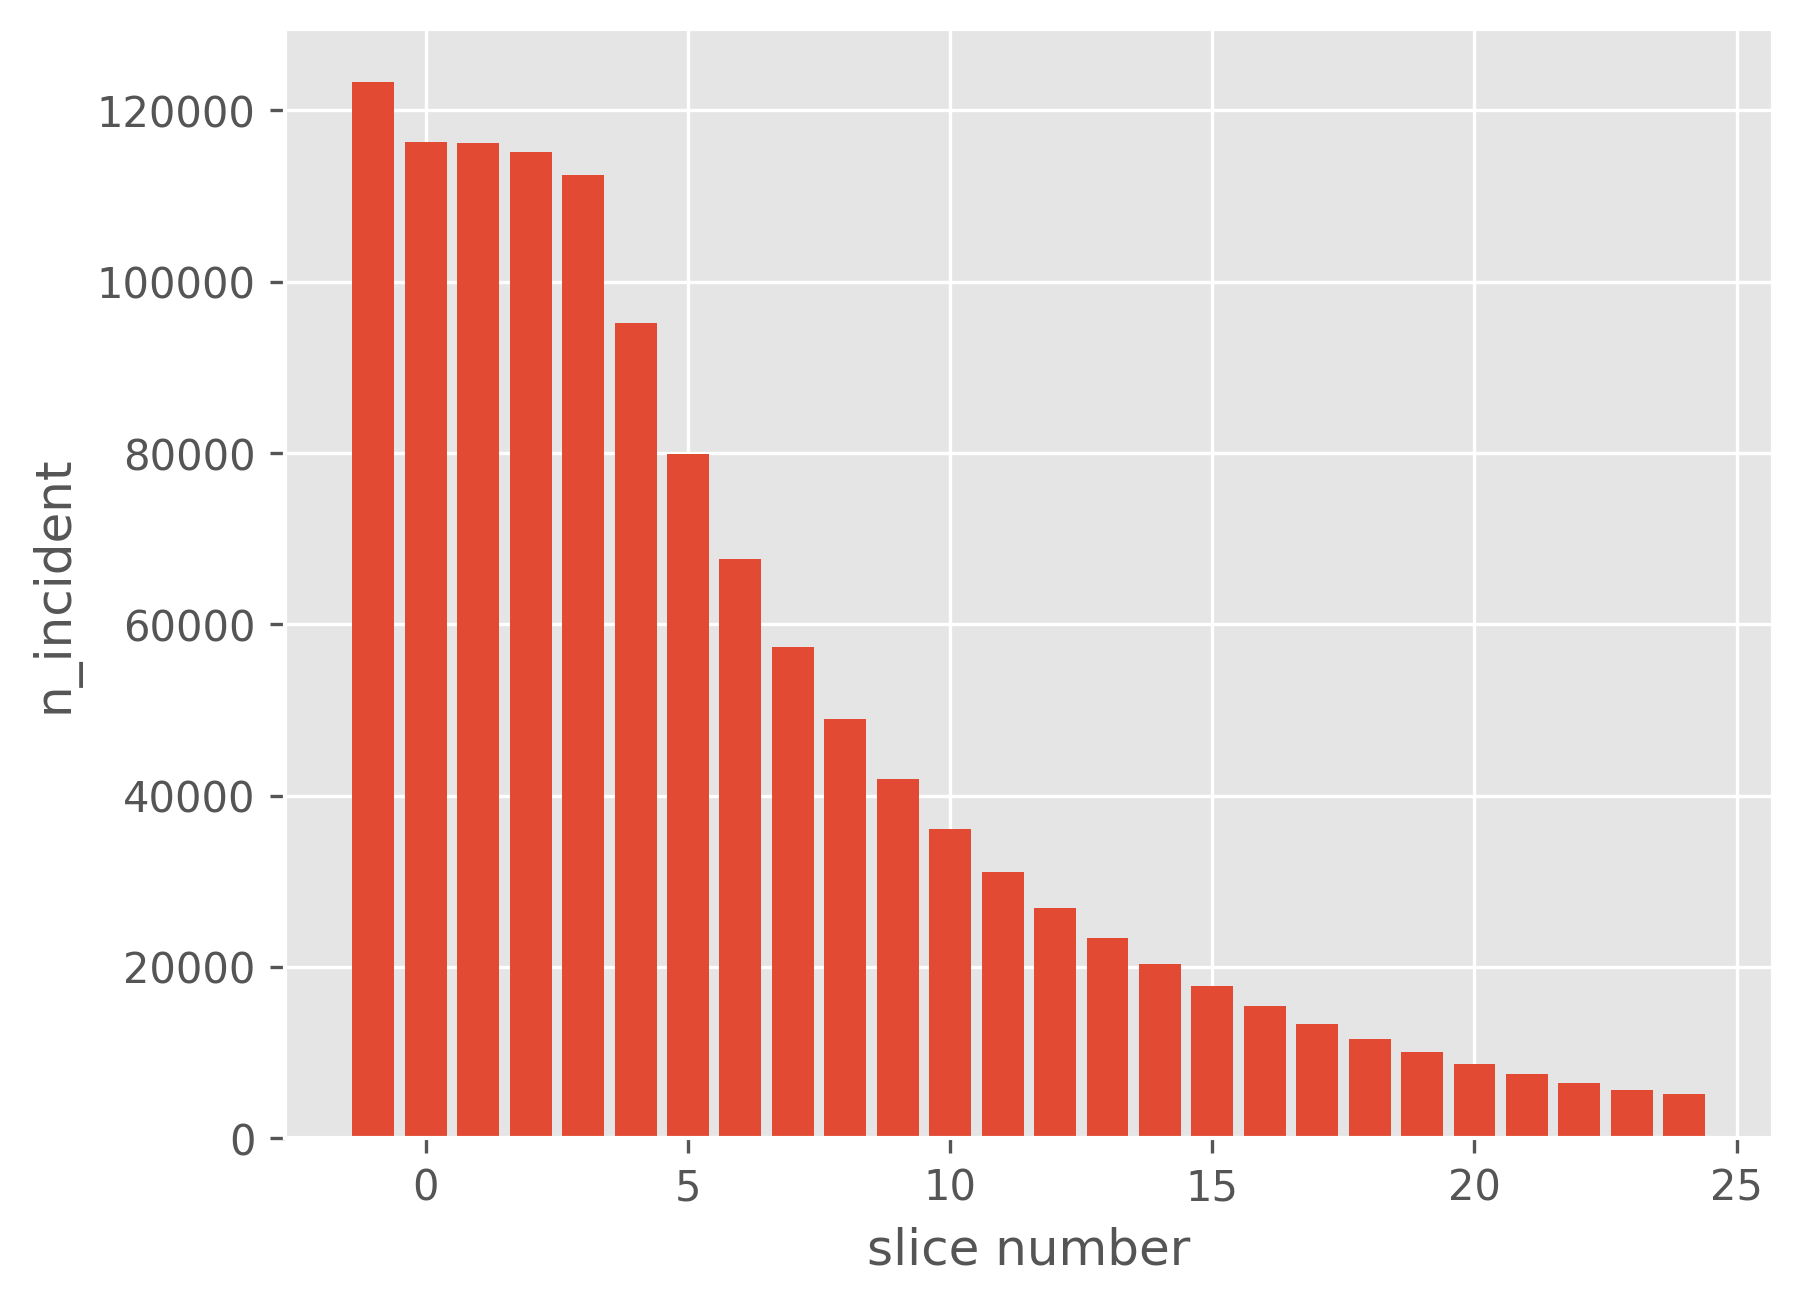

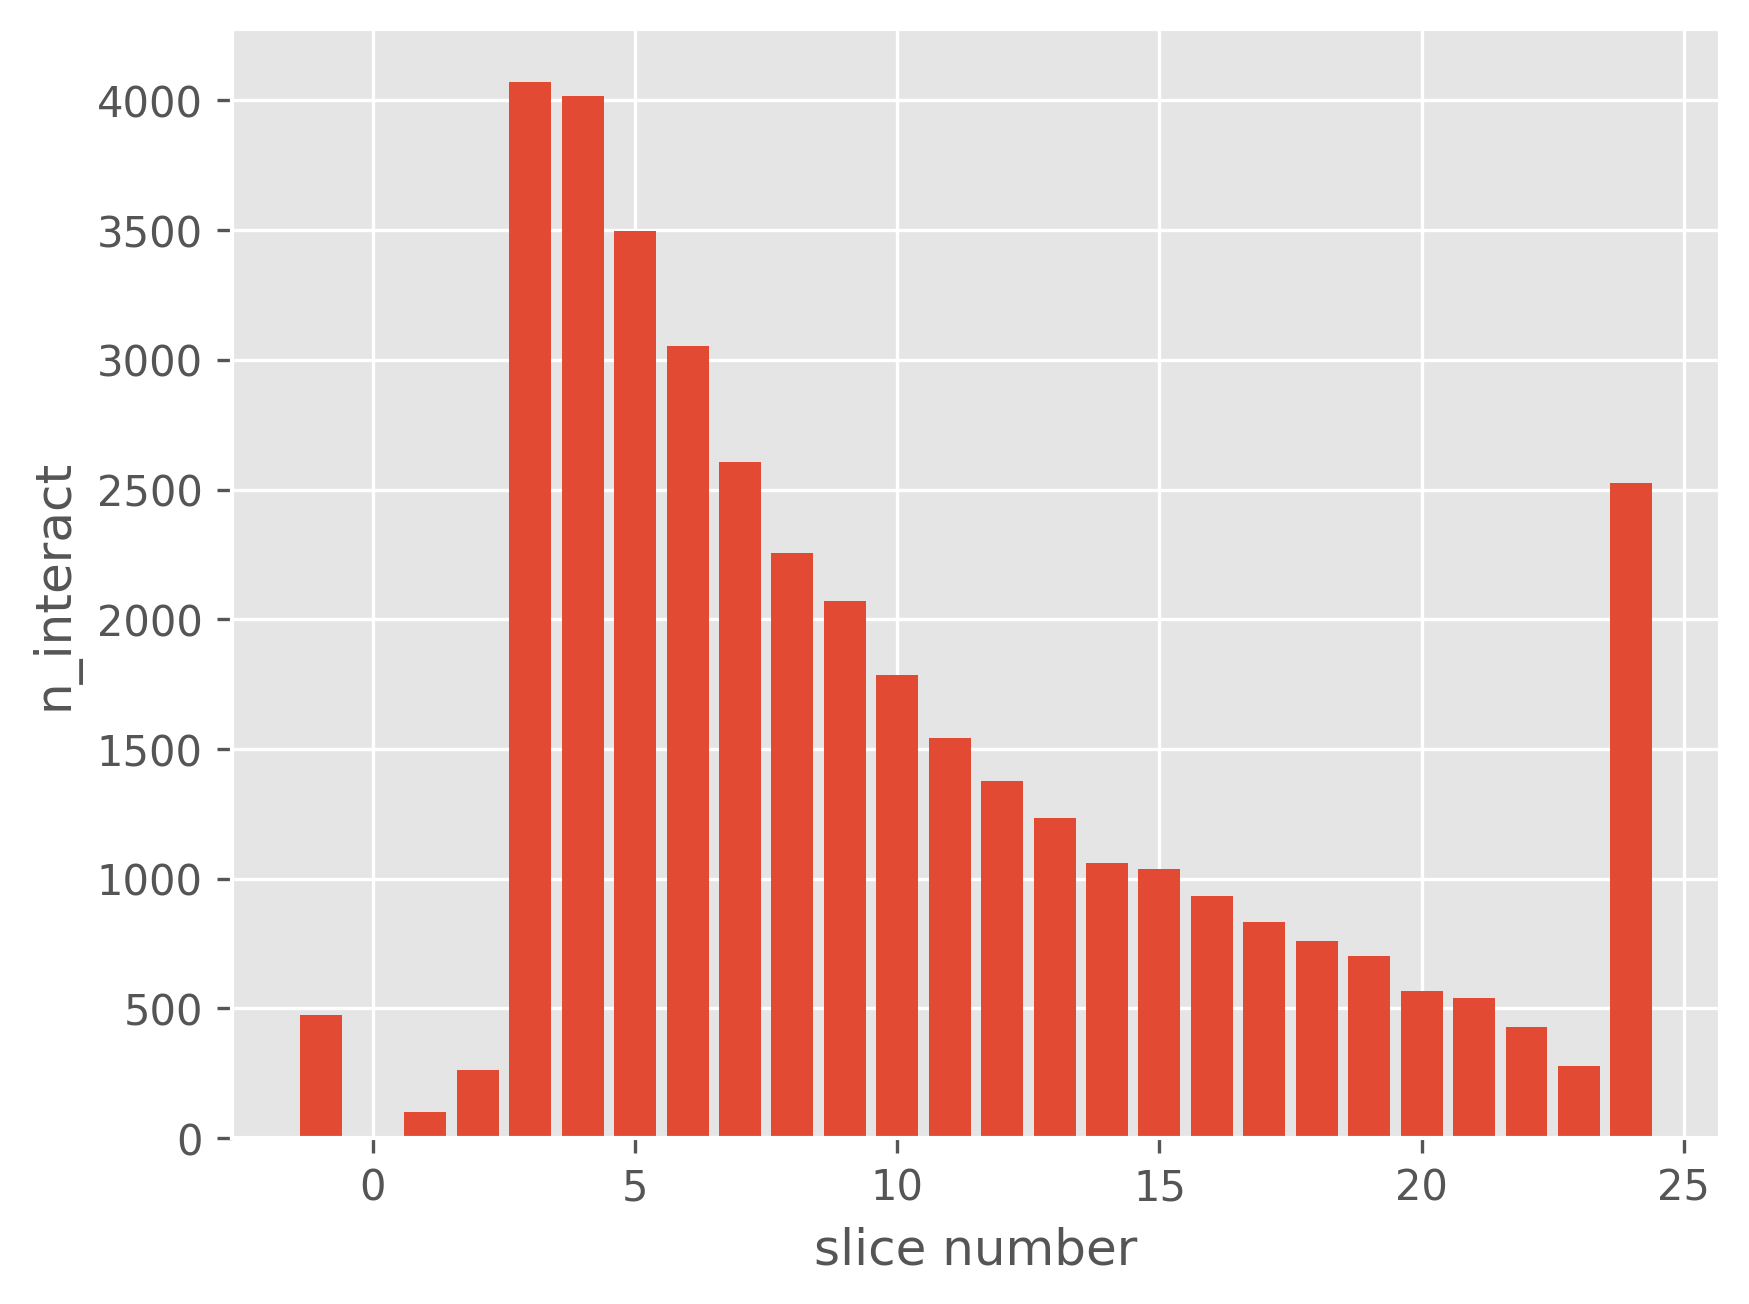

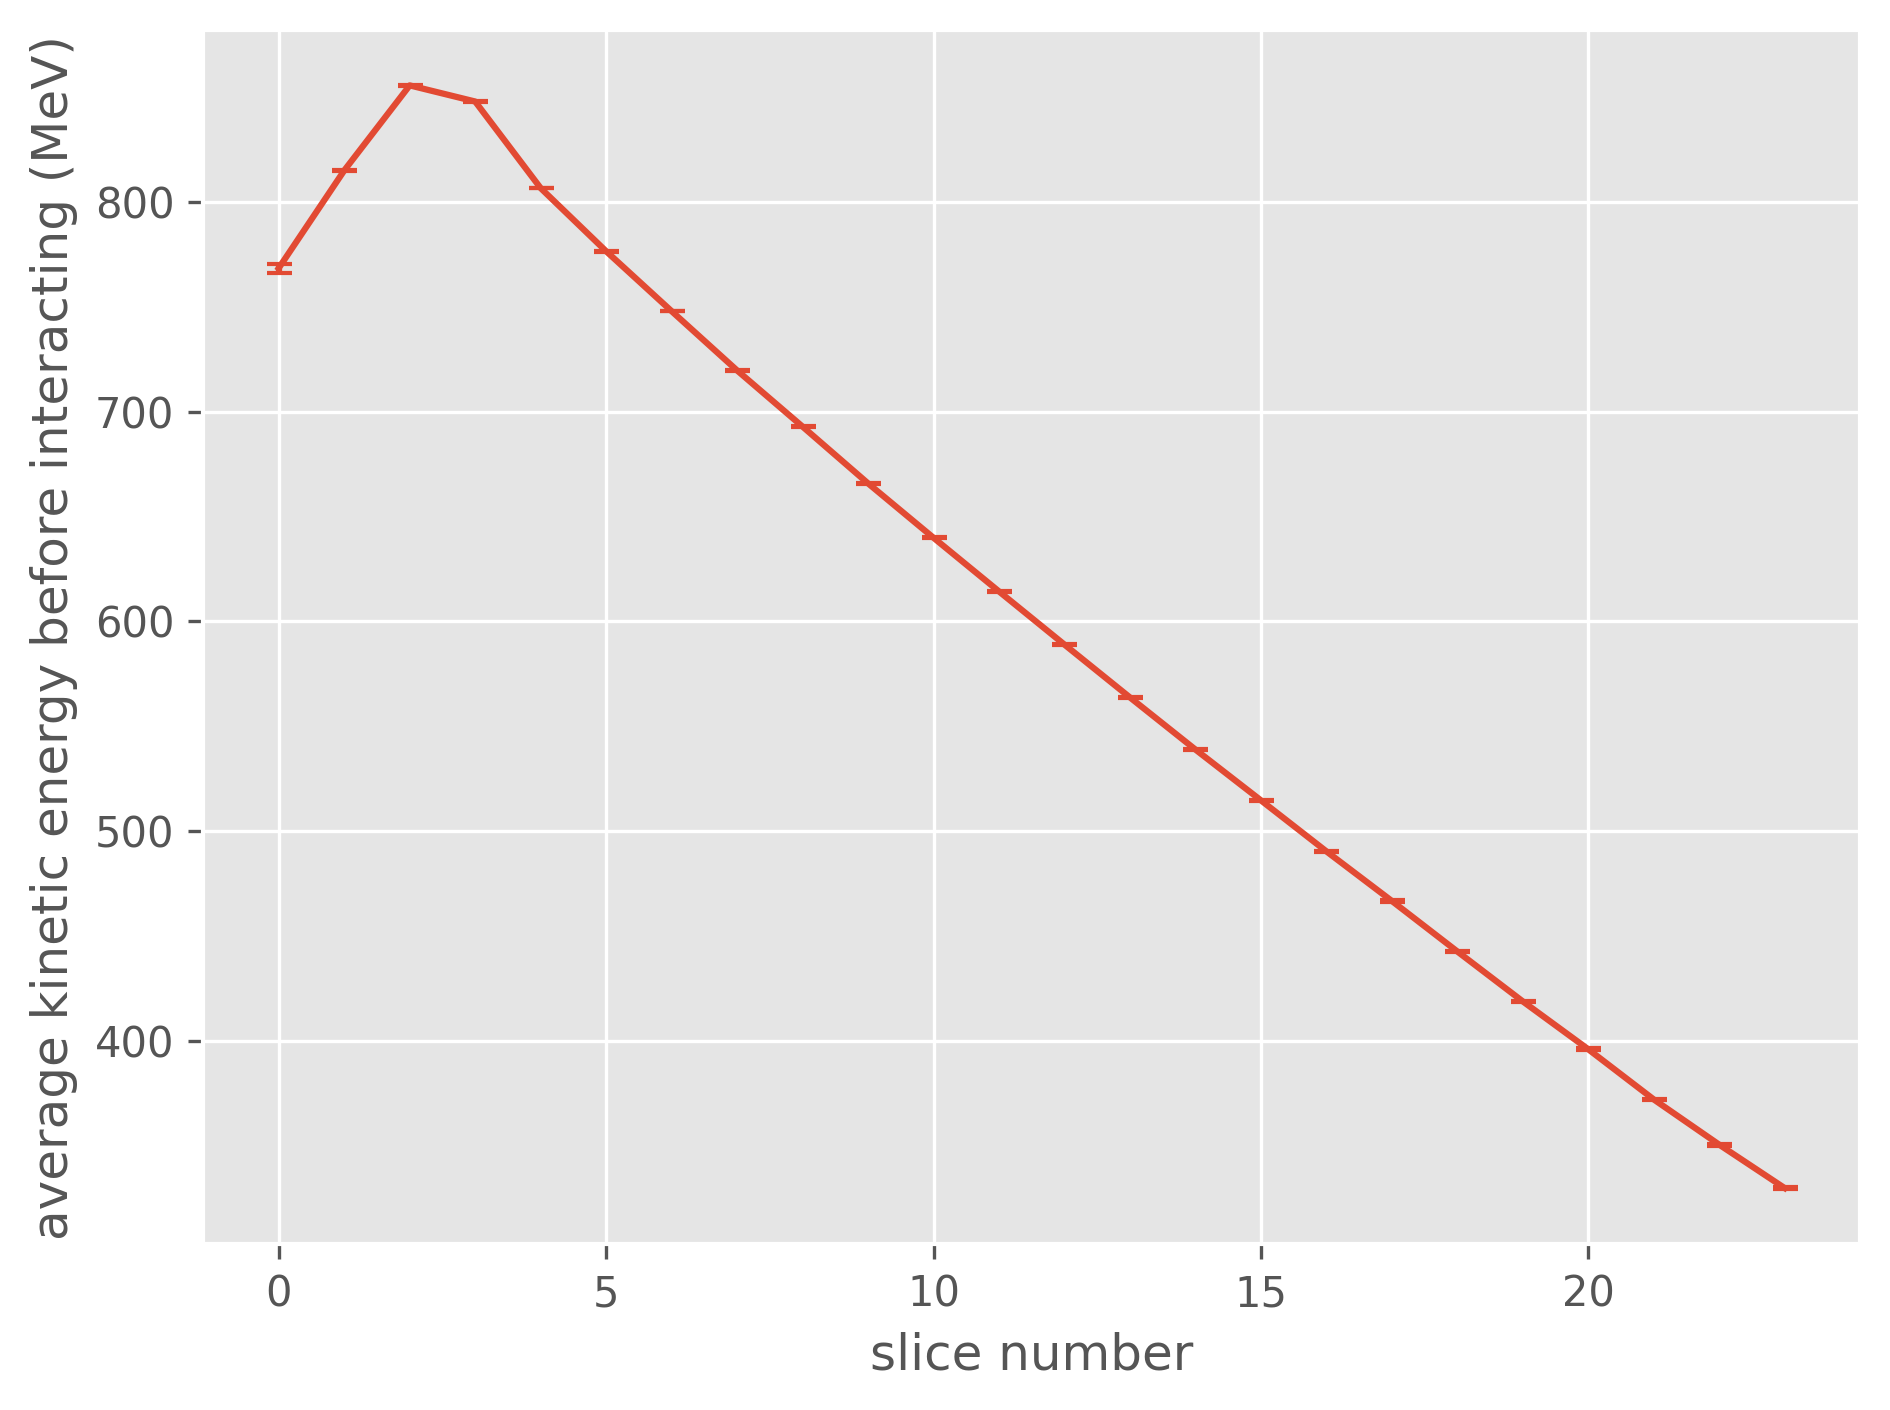

In [96]:
inelastic = events.trueParticles.true_beam_endProcess == "pi+Inelastic"
absorption = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 0)
cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 1)

slice_masks = ThinSlice.SliceMasks(events.trueParticles.beam_traj_pos.z[:, -1], slices)
n_incident = ThinSlice.Incident(slice_masks, slices)
n_interact = ThinSlice.CountingExperiment(slice_masks, absorption & inelastic)

#* visualise the histograms
plt.figure()
plt.bar(slices.num, n_incident)
plt.xlabel("slice number")
plt.ylabel("n_incident")
# hist_glow()

plt.figure()
plt.bar(slices.num, n_interact)
plt.xlabel("slice number")
plt.ylabel("n_interact")
# hist_glow()


n_incident_error = np.sqrt(n_incident)
n_interact_error = np.sqrt(n_interact)

xs = ThinSlice.CrossSection(n_incident, n_interact, 10)
mean_slice_energy = ThinSlice.MeanSliceEnergy(slices, events.trueParticles.beam_traj_pos.z[:, :-1], events.trueParticles.true_beam_traj_KE[:, :-1])

mean_error_slice_energy = slices.std(events.trueParticles.beam_traj_pos.z[:, :-1], events.trueParticles.true_beam_traj_KE[:, :-1]) / np.sqrt(slices.count(events.trueParticles.beam_traj_pos.z[:, :-1]))

Plots.Plot(slices.num[1:-1], (mean_slice_energy)[1:-1], yerr = mean_error_slice_energy[1:-1], xlabel = "slice number", ylabel = "average kinetic energy before interacting (MeV)")


Plot the cross section as a function of slice number

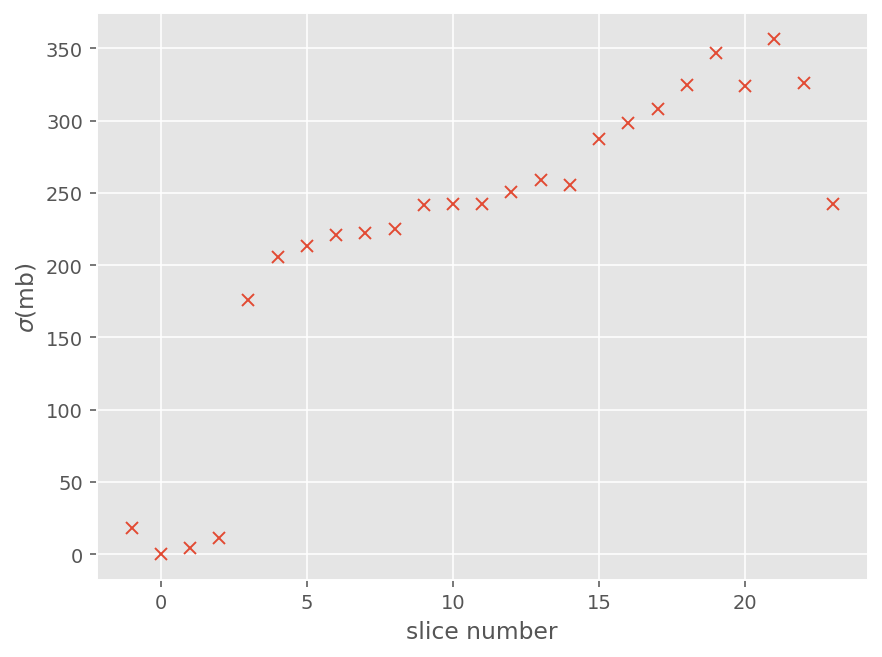

In [67]:
Plots.Plot(slices.num[0:-1], xs[0][0:-1], xlabel = "slice number", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False)
# mplcyberpunk.add_glow_effects()

Plot the cross section as a function of the avergae $\pi^{+}$ Kinetic energy in each slice

(0.0, 1500.0)

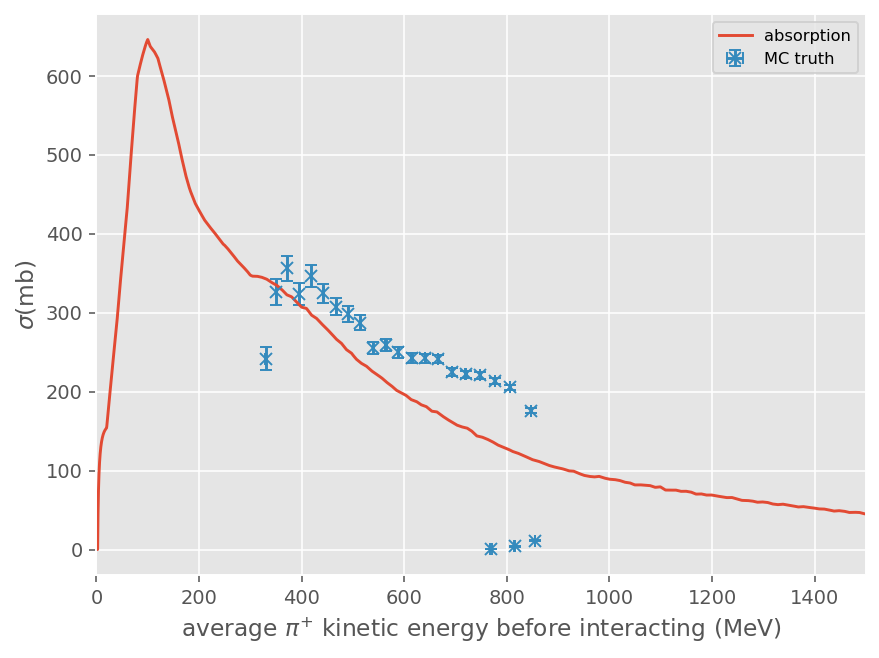

In [25]:
cross_sections.Plot("absorption")
Plots.Plot(mean_slice_energy[1:-1], xs[0][1:-1], yerr = xs[1][1:-1], xerr = mean_error_slice_energy[1:-1], xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = "MC truth")
plt.xlim(0, 1500)
# mplcyberpunk.add_glow_effects()

n_incident calculated

mean energy of slice calculated

evaluating total_inelastic region

evaluating absorption region

evaluating charge_exchange region

evaluating quasielastic region

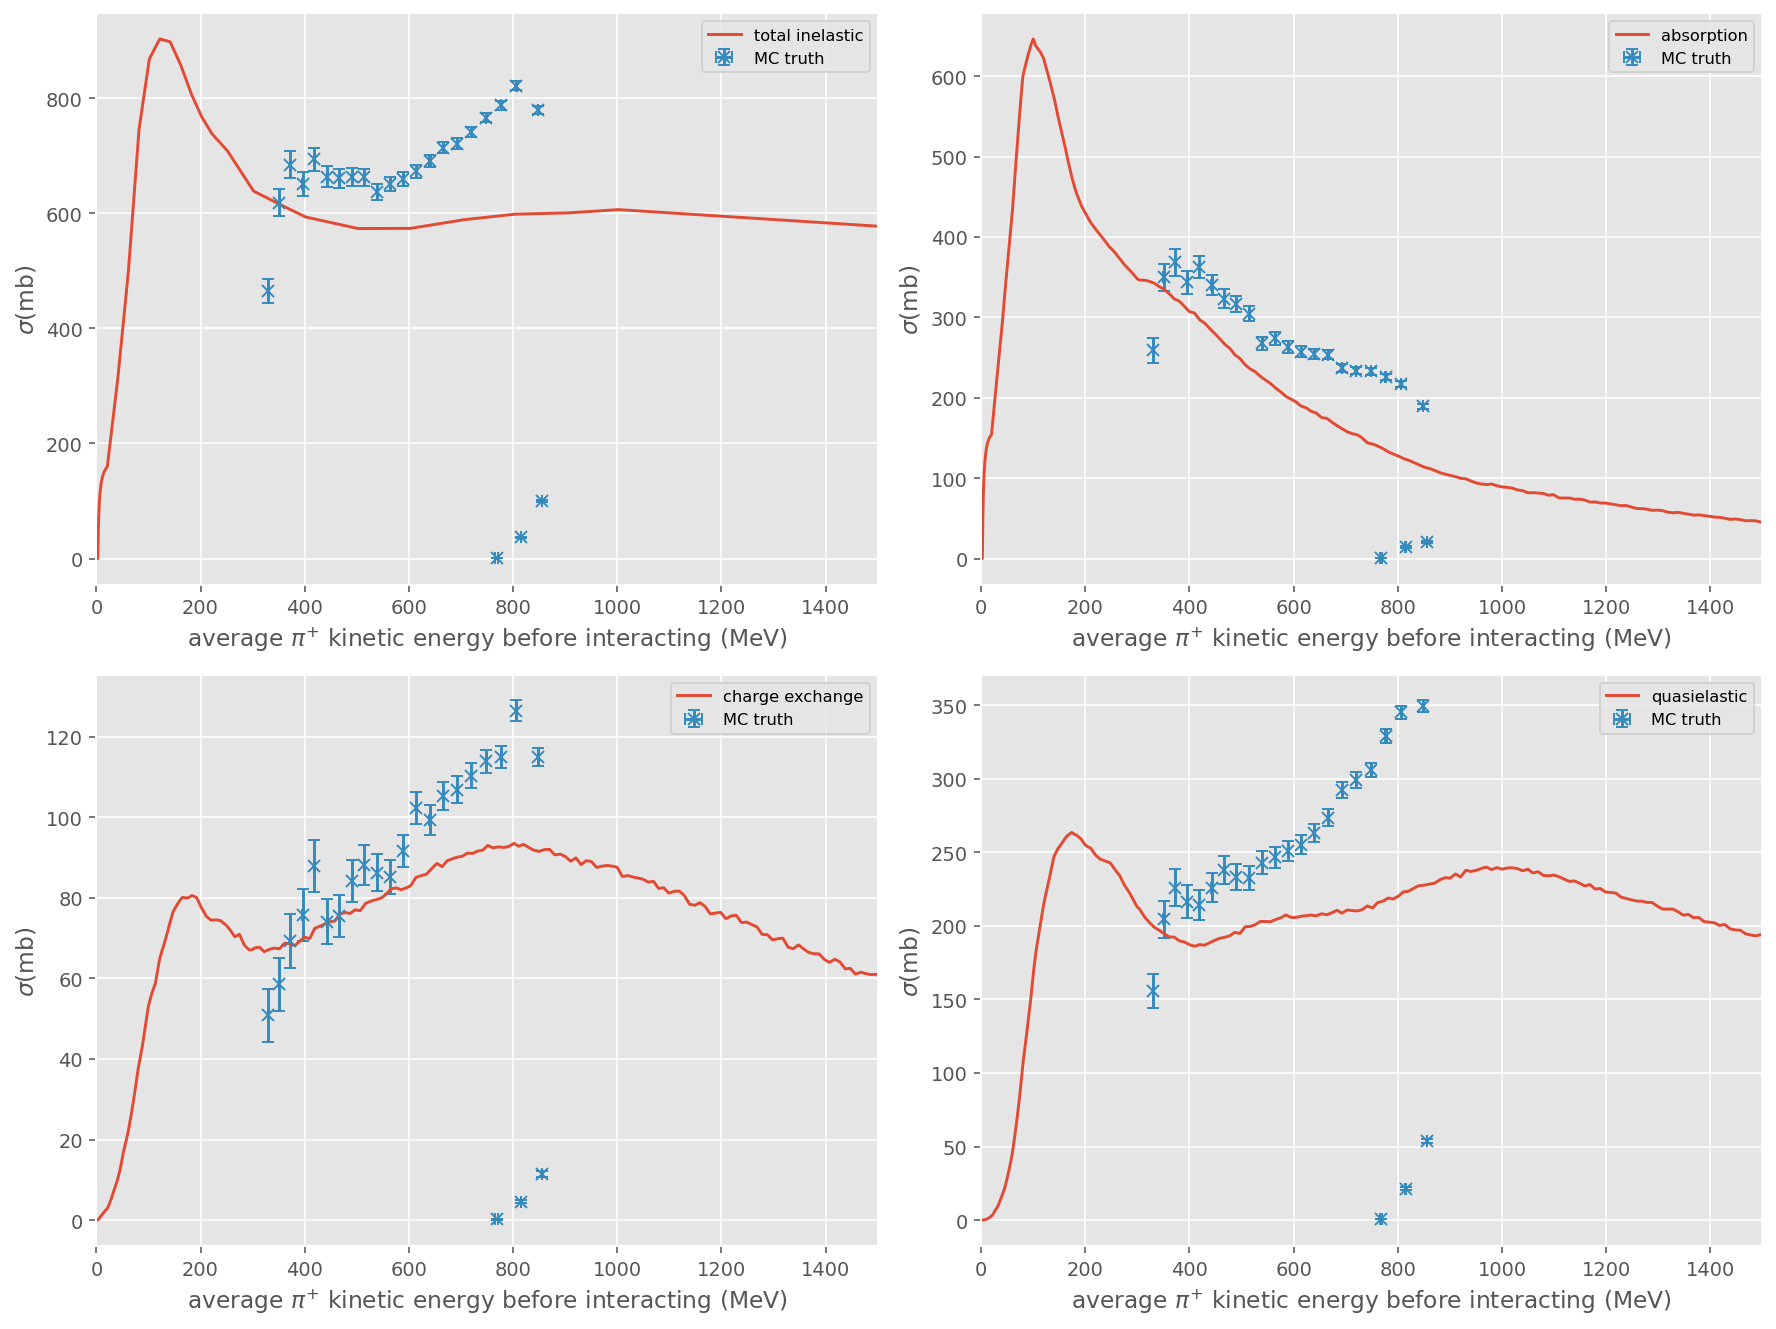

In [73]:
def ThinSliceDemo():
    cross_sections = CrossSections("test/g4_xs.root")
    ts = ThinSlice(events.trueParticles.beam_traj_pos.z[:, -1], 0, 230, 10)
    print("n_incident calculated")
    mean_slice_energy = ThinSlice.MeanSliceEnergy(ts.slices, events.trueParticles.beam_traj_pos.z[:, :-1], events.trueParticles.true_beam_traj_KE[:, :-1])
    mean_error_slice_energy = slices.std(events.trueParticles.beam_traj_pos.z[:, :-1], events.trueParticles.true_beam_traj_KE[:, :-1]) / np.sqrt(slices.count(events.trueParticles.beam_traj_pos.z[:, :-1]))
    print("mean energy of slice calculated")

    regions = truth_regions(events)
    for i, region in Plots.IterMultiPlot(regions):
        print(f"evaluating {region} region")
        n_interact = ts.CountingExperiment(ts.slice_masks, regions[region])
        xs = ThinSlice.CrossSection(n_incident, n_interact, 10)
        cross_sections.Plot(region)
        Plots.Plot(mean_slice_energy[1:-1], xs[0][1:-1], yerr = xs[1][1:-1], xerr = mean_error_slice_energy[1:-1], xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = "MC truth")
        plt.xlim(0, 1500)

ThinSliceDemo()
    

In [98]:
for i, s in Plots.IterMultiPlot(slices):
    mask = slices.pos_to_num(events.trueParticles.beam_traj_pos.z[:, :-1]) == s.num
    energy = events.trueParticles.true_beam_traj_KE[:, :-1][mask]
    Plots.PlotHist(ak.ravel(energy), newFigure = False, title = s.__str__(), range = [0, 1500], xlabel = "True Kinetic Energy (MeV)")

[   0   50  100  150  200  250  300  350  400  450  500  550  600  650
  700  750  800  850  900  950 1000]

n_interact=array([1.000e+00, 1.000e+01, 4.100e+01, 7.800e+01, 9.200e+01, 1.330e+02,
       1.800e+02, 2.650e+02, 4.080e+02, 4.810e+02, 7.060e+02, 9.710e+02,
       1.430e+03, 1.905e+03, 2.388e+03, 3.006e+03, 2.793e+03, 1.834e+03,
       7.410e+02, 1.020e+02])

n_incident=array([  9547.,  12052.,  16411.,  22704.,  29728.,  39743.,  52075.,
        64023.,  79157.,  98558., 122051., 155023., 198099., 255409.,
       343941., 528622., 804163., 807582., 502873., 138077.])

(0.0, 1200.0)

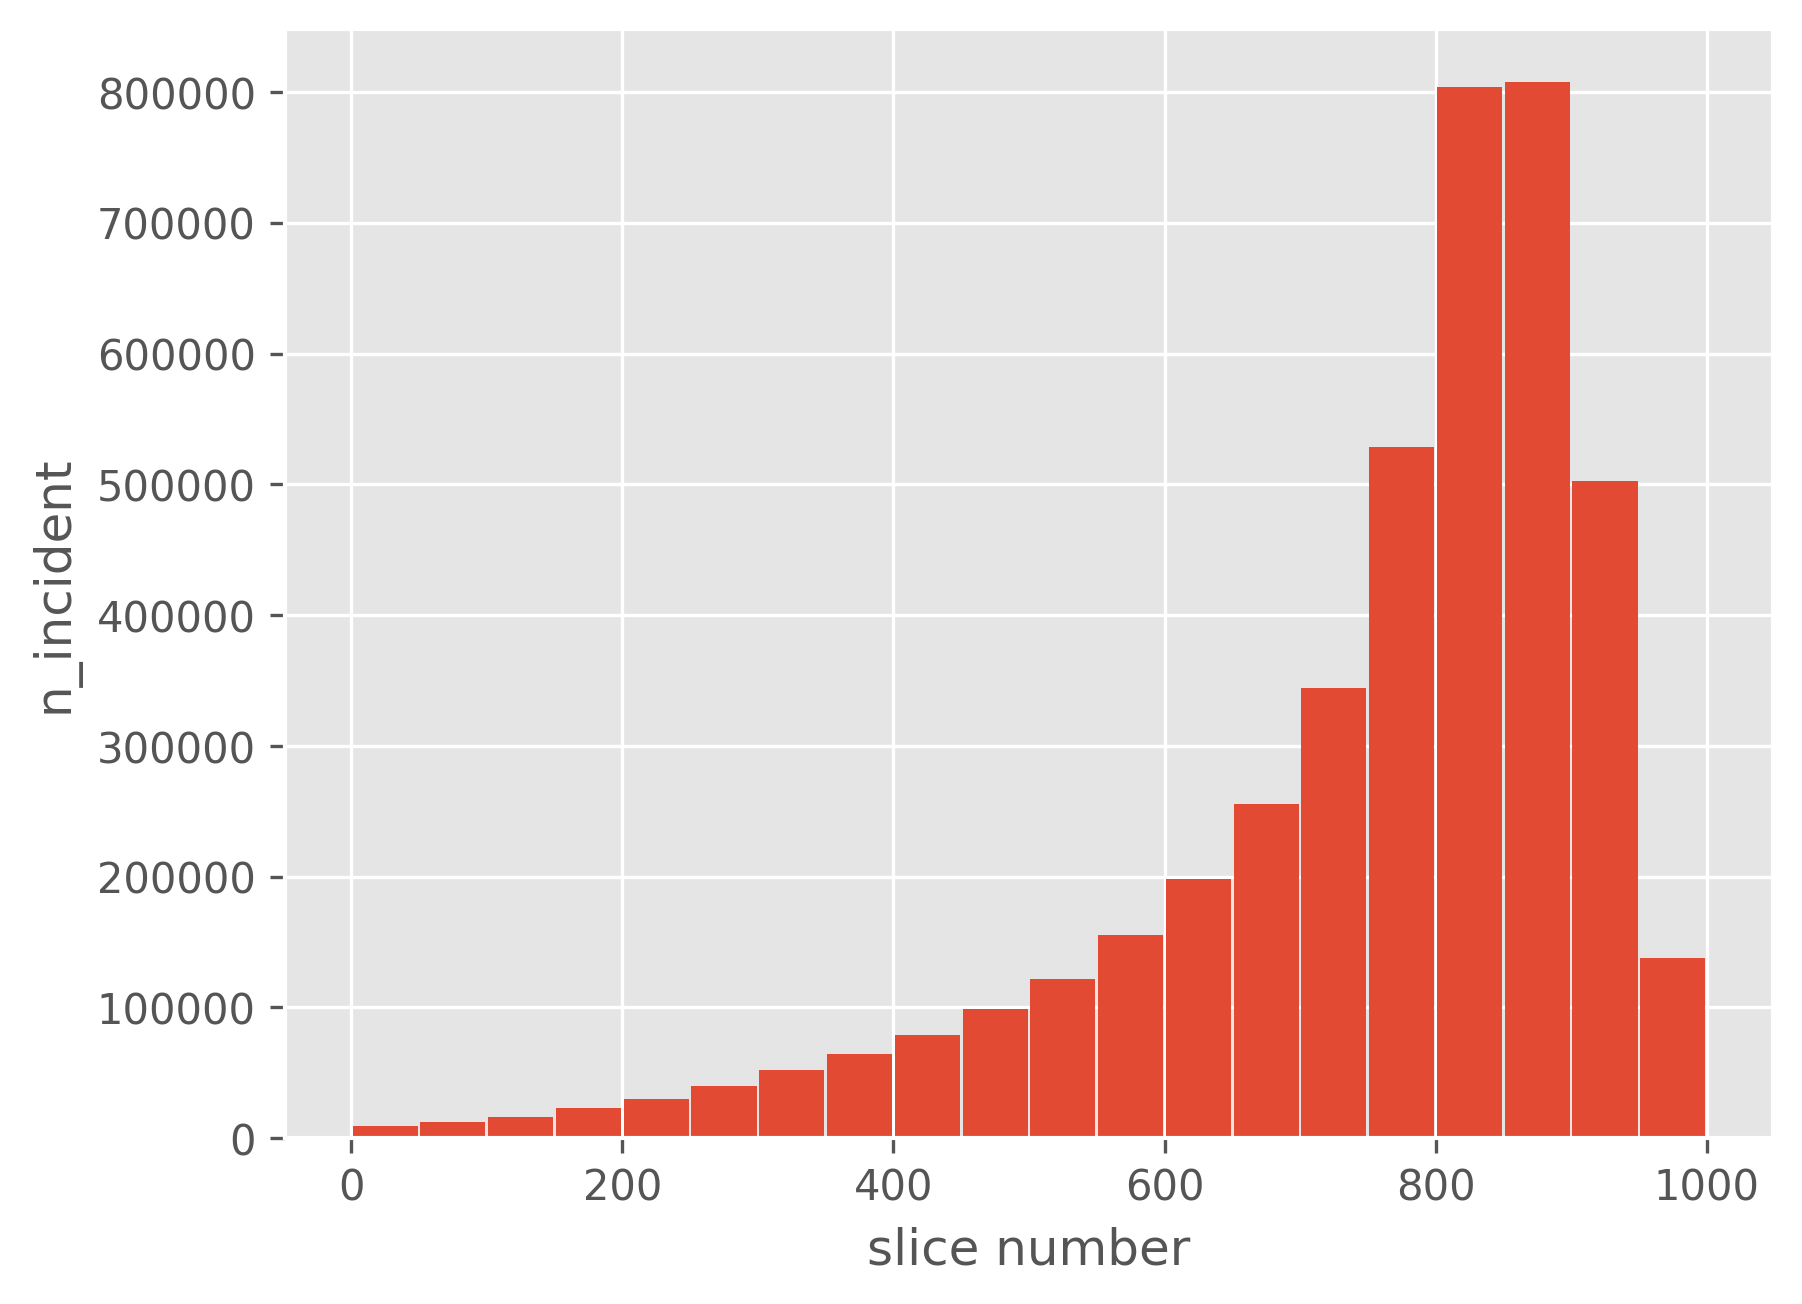

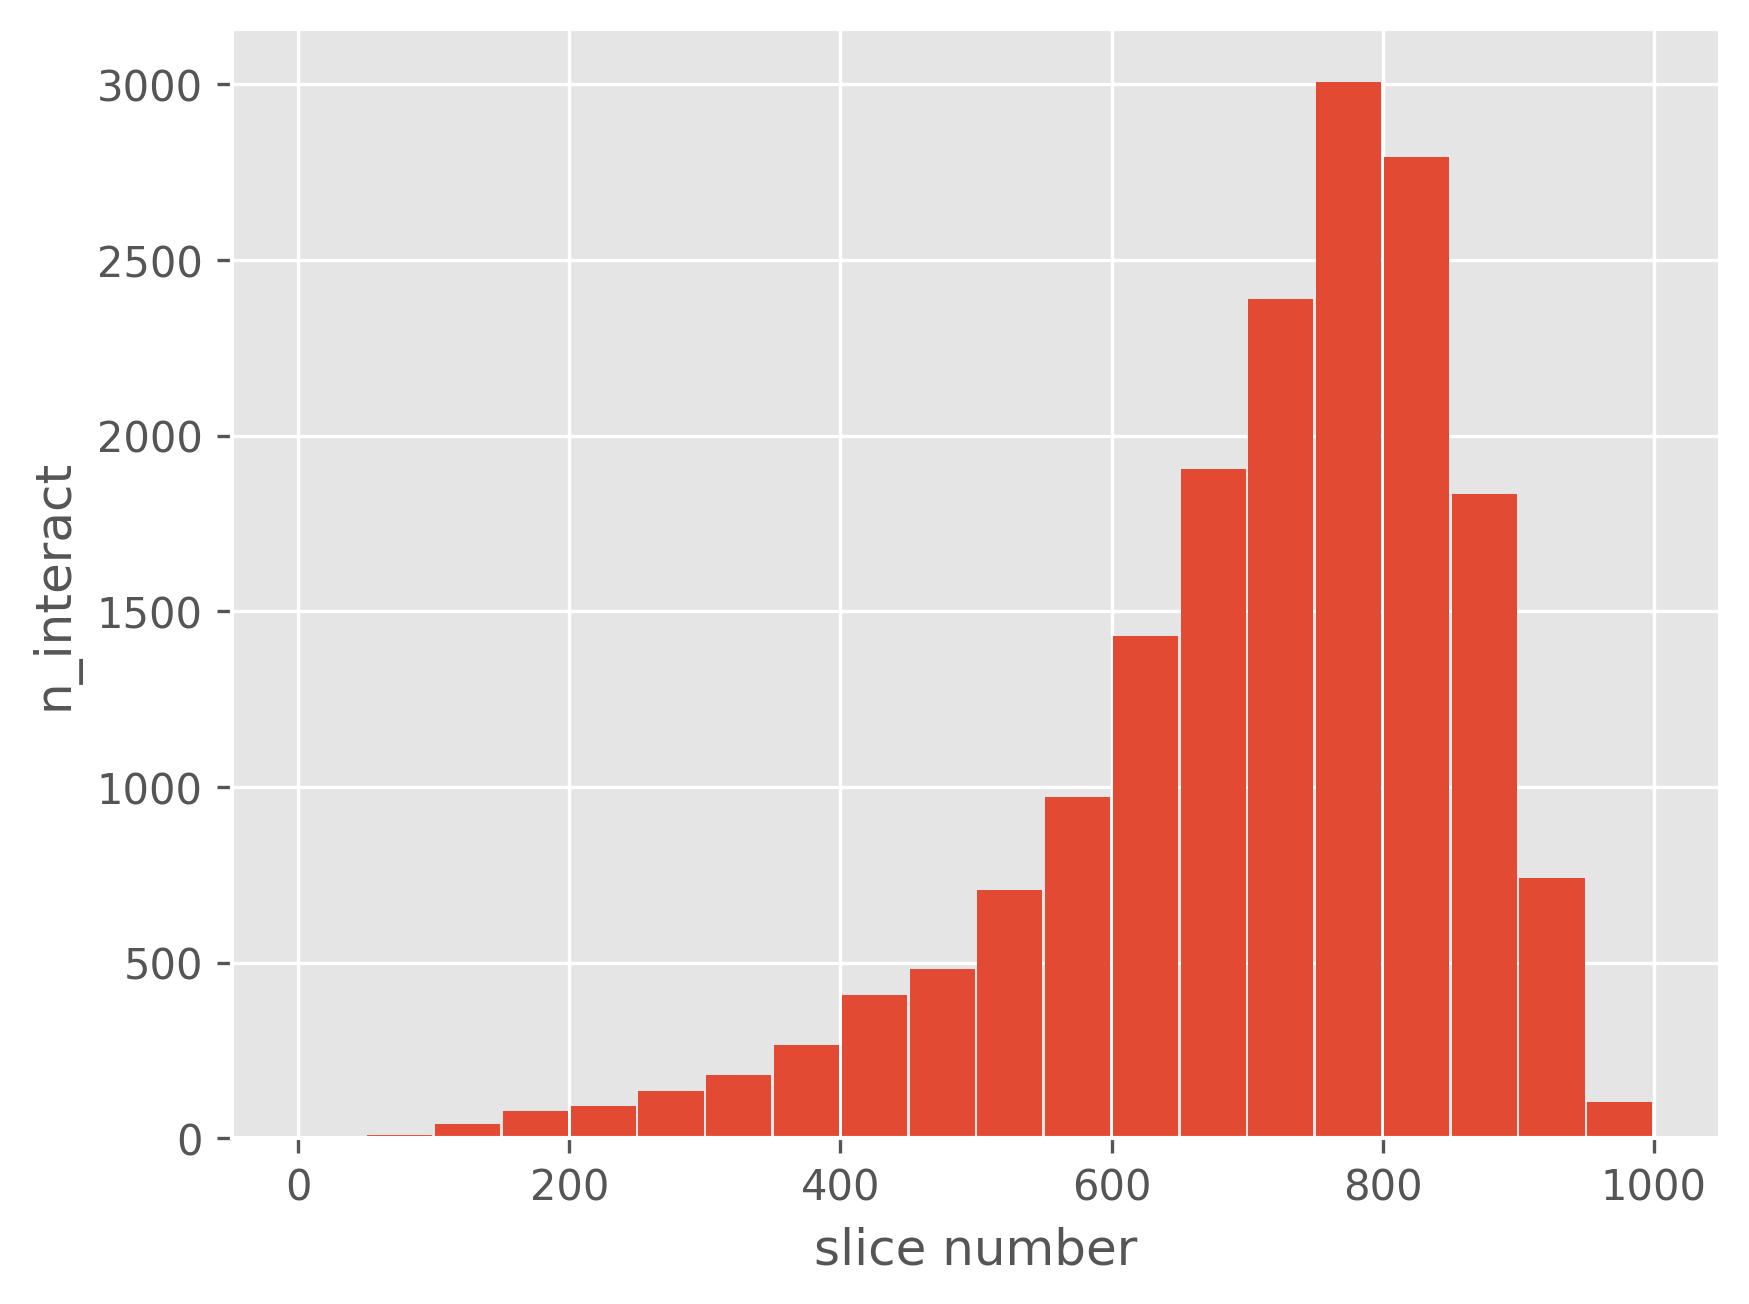

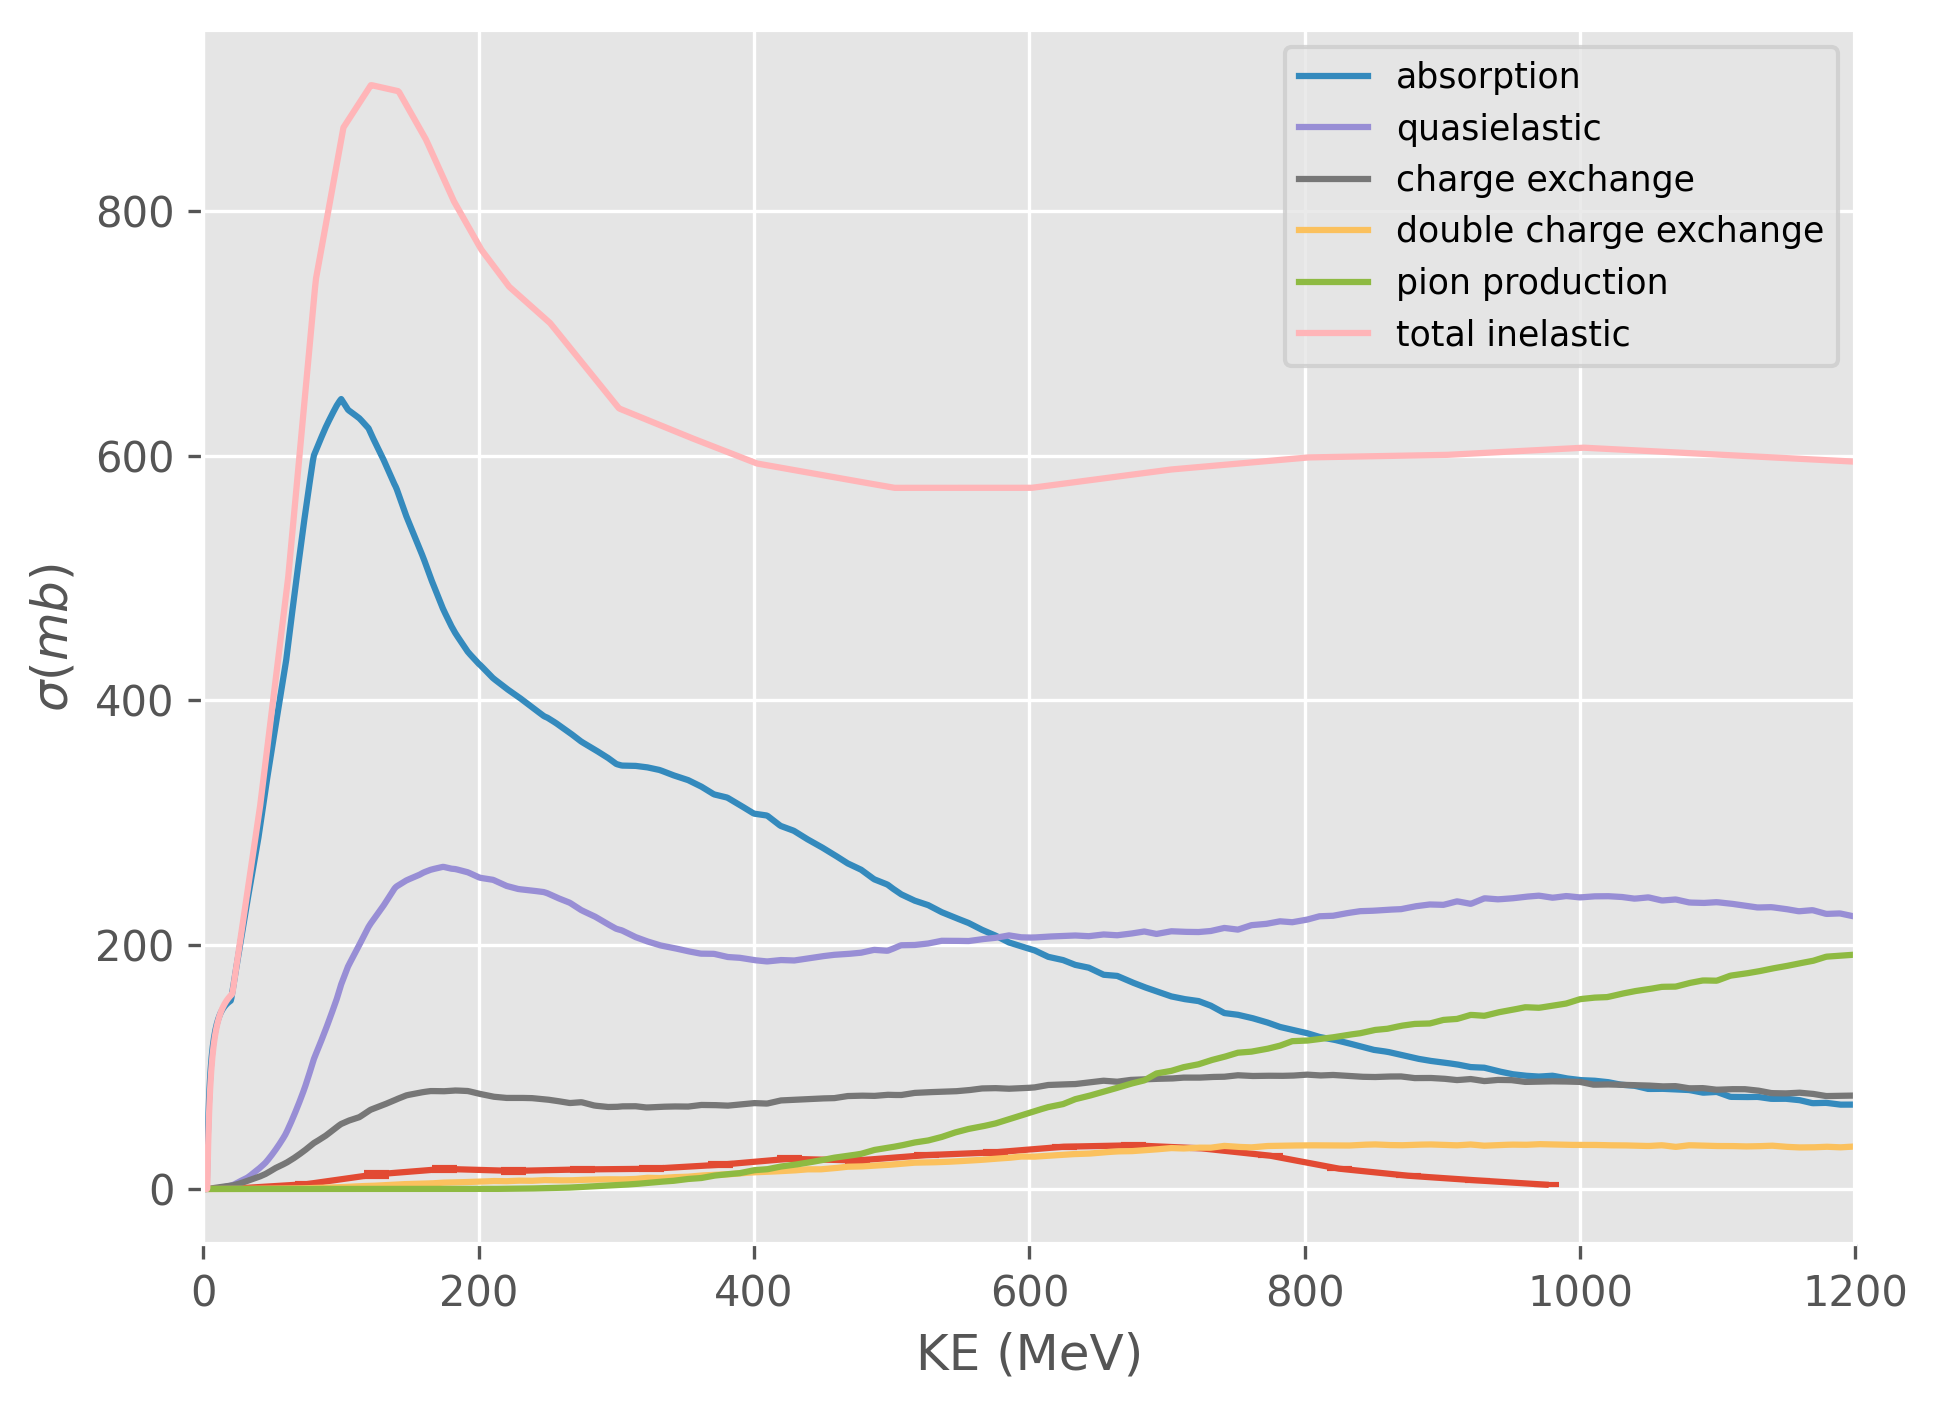

In [99]:
slices = ThinSlice.CreateThinSlices(0, 230, 10)
# slice_masks = ThinSlice.SliceMasks(events.trueParticles.beam_traj_pos.z, slices)

num = slices.pos_to_num(events.trueParticles.beam_traj_pos.z)

energy_bins = np.arange(0, 1050, 50)
print(energy_bins)
n_incident = np.zeros(len(energy_bins)-1)
n_interact = np.zeros(len(energy_bins)-1)

for s in slices:
    # print(s)

    n_incident_mask = num == s.num
    energy_incident = events.trueParticles.beam_traj_KE[n_incident_mask]

    n_interact_mask = num[:, -1] == s.num
    energy_interact = events.trueParticles.beam_traj_KE[:, -2][n_interact_mask & cex]

    for e in range(len(energy_bins) - 1):
        in_bin = (energy_incident > energy_bins[e]) & (energy_incident < energy_bins[e + 1])
        n_incident[e] += ak.sum(in_bin)

        in_bin = (energy_interact > energy_bins[e]) & (energy_interact < energy_bins[e + 1])
        n_interact[e] += ak.sum(in_bin)

print(f"{n_interact=}")
print(f"{n_incident=}")

#* visualise the histograms
plt.figure()
plt.bar((energy_bins[1:] + energy_bins[:-1]) / 2, n_incident, 48)
plt.xlabel("slice number")
plt.ylabel("n_incident")
# hist_glow()

plt.figure()
plt.bar((energy_bins[1:] + energy_bins[:-1]) / 2, n_interact, 48)
plt.xlabel("slice number")
plt.ylabel("n_interact")

xs = ThinSlice.CrossSection(n_incident, n_interact, slices.width)

Plots.Plot((energy_bins[1:] + energy_bins[:-1]) / 2, xs[0], yerr = xs[1])
cross_sections.Plot("all")
plt.xlim(0, 1200)


# Slices Based on Energy

instead of computing the slices based on the wire pitch, use the energy loss of the particle and define slices in energy instead. This means the slice thickness is now in terms of $\delta E$ and the spacial thickness is:

$$
    t_{i} = \frac{\delta E}{ \left.\frac{dE}{dX}\right|_{\left< E_{i} \right>} }
$$

where i is the slice number, $dE/dX$ is the energy loss per unit length and $E_{i}$ is the particle energy exiting the slice.

i.e. the slice thickness is the distance the particle travels before it looses $\delta E$ worth of energy.

Now the cross section formula becomes:

$$
\sigma_{i} = \frac{M_{Ar}}{\rho N_{A} \delta E} \left.\frac{dE}{dX}\right|_{\left< E_{i} \right>} \log\left( \frac{N_{incident}}{N_{incident} - N_{interact}} \right)
$$

And really is a function of the particle kinetic energy rather than the averge kinetic energy in a slice.

By convention, $\delta E$ is set to 50MeV (not sure why) and now the slice thickness need to be calculated per particle

Now, the counting will work in a similar way, but we can no longer assume the particle travels through all slices because the initial kinetic energy of the beam particle vill vary. So as well as the end slice, an initial slice must be found.

The initial slice is `ceil((plim - KE_ini)//dE)`

The end slice is still the last trajectory point, but the slice number needs to be found based on the energy the particle had before interacting with the target

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:156: RuntimeWarning: divide by zero encountered in divide
  dEdX = (BetheBloch.rho * BetheBloch.K * BetheBloch.Z * (particle.charge)**2) / (BetheBloch.A * beta**2) * (0.5 * np.log(2 * BetheBloch.me * (gamma**2) * (beta**2) * w_max / (BetheBloch.I**2)) - beta**2 - (BetheBloch.densityCorrection(beta, gamma) / 2))
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:156: RuntimeWarning: divide by zero encountered in log
  dEdX = (BetheBloch.rho * BetheBloch.K * BetheBloch.Z * (particle.charge)**2) / (BetheBloch.A * beta**2) * (0.5 * np.log(2 * BetheBloch.me * (gamma**2) * (beta**2) * w_max / (BetheBloch.I**2)) - beta**2 - (BetheBloch.densityCorrection(beta, gamma) / 2))
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:134: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(beta * gamma)
/home/sb16165/Documents/pi0-analysis/analysis/python/a

[0, 3.35, 2.5, 2.26, 2.16, 2.12, 2.1, ... 2.17, 2.18, 2.19, 2.2, 2.21, 2.22, 2.23]

[   0   50  100  150  200  250  300  350  400  450  500  550  600  650
  700  750  800  850  900  950 1000 1050]

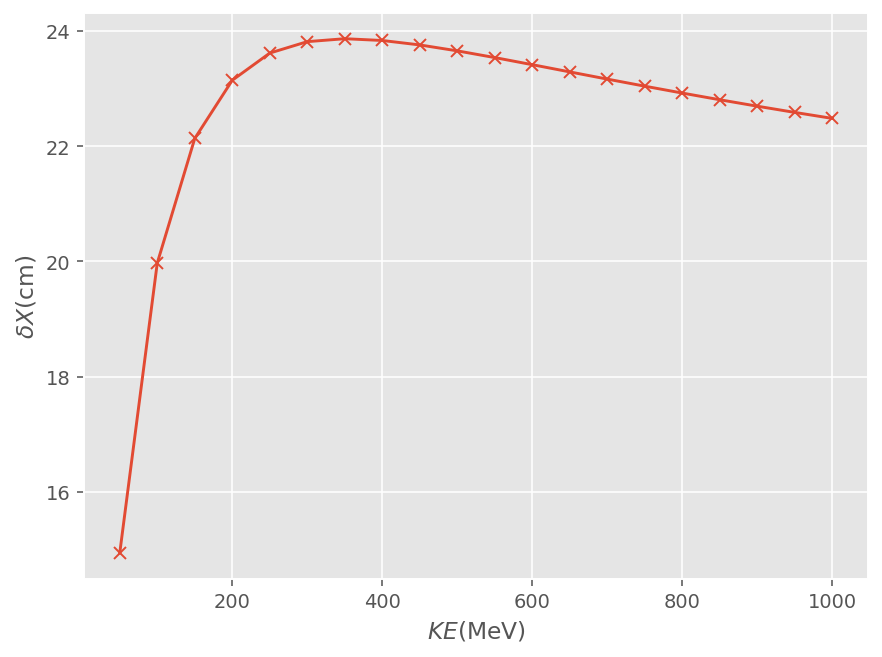

In [55]:
energy_slices = ThinSlice.CreateThinSlices(50, 1000, 50)

mean_dEdX = cross_section.BetheBloch.meandEdX(energy_slices.pos, Particle.from_pdgid(211))

print(mean_dEdX)

print(energy_slices.pos)
Plots.Plot(energy_slices.pos[1:-1],  (energy_slices.width/mean_dEdX)[1:-1], xlabel = "$KE$(MeV)", ylabel = "$\delta X$(cm)", marker = "x")

In [57]:
slice_masks = ThinSlice.SliceMasks(events.trueParticles.beam_traj_KE[:, -2], energy_slices)
n_incident = ThinSlice.Incident(slice_masks[::-1], energy_slices)
n_incident = n_incident[::-1]

print(n_incident)
n_interact = ThinSlice.CountingExperiment(slice_masks, truth_regions(events)["total_inelastic"])
#! this method does not work because not all pions have the same initial kinetic energy

[   772   1010   1555   2342   3331   4706   6441   8781  11980  15974
  21284  28242  37514  49631  65387  84426 103241 116194 121842 122940
 123040 123278]

In [93]:
first_in_tpc = ak.argmax(events.trueParticles.beam_traj_pos.z > 0, axis = 1, keepdims = True)
first_KE = ak.flatten(events.trueParticles.beam_traj_KE[first_in_tpc])
first_slice = energy_slices.pos_to_num(first_KE)
end_slice = energy_slices.pos_to_num(events.trueParticles.beam_traj_KE[:, -2])
print(first_slice)
print(end_slice)

n_incident = np.zeros(len(energy_slices), dtype = int)
for f, e in zip(first_slice, end_slice):
    n_incident[e : f+1] += 1

n_interact = ThinSlice.CountingExperiment(slice_masks, truth_regions(events)["total_inelastic"])

print(n_incident)
print(n_interact)

[15, 18, 18, 18, 15, 16, 16, 18, 18, 15, ... 15, 18, 17, 18, 16, 18, 19, 16, 18, 16]

[15, 12, 18, 5, 3, 15, 7, 16, 14, 7, 15, ... 13, 16, 17, 14, 10, 16, 18, 13, 17, 14]

[  772  1010  1554  2341  3330  4702  6436  8773 11964 15954 21247 28174
 37399 49285 64102 79839 86243 66854 33245  7780   564   409]

[   31   222   519   751   954  1339  1678  2279  3123  3887  5185  6793
  9101 11933 15435 18472 17758 11803  4894   877    86   222]

Text(0, 0.5, 'counts')

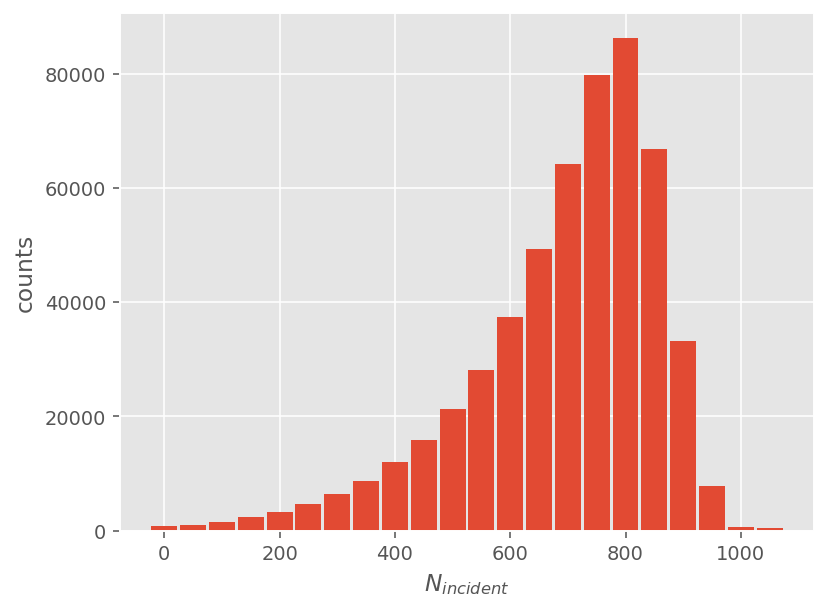

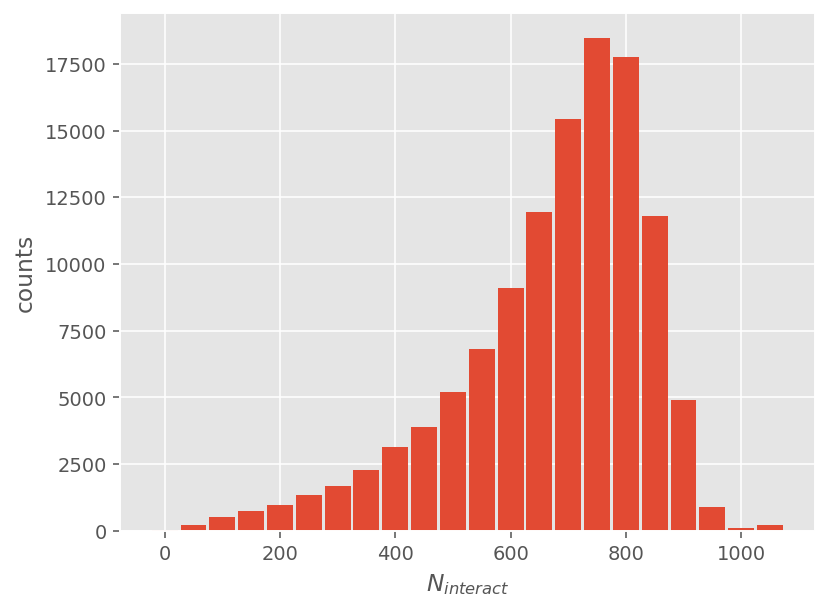

In [94]:
plt.figure()
plt.bar(energy_slices.pos, n_incident, 45)
plt.xlabel("$N_{incident}$")
plt.ylabel("counts")
plt.figure()
plt.bar(energy_slices.pos, n_interact, 45)
plt.xlabel("$N_{interact}$")
plt.ylabel("counts")

(0.0, 1250.0)

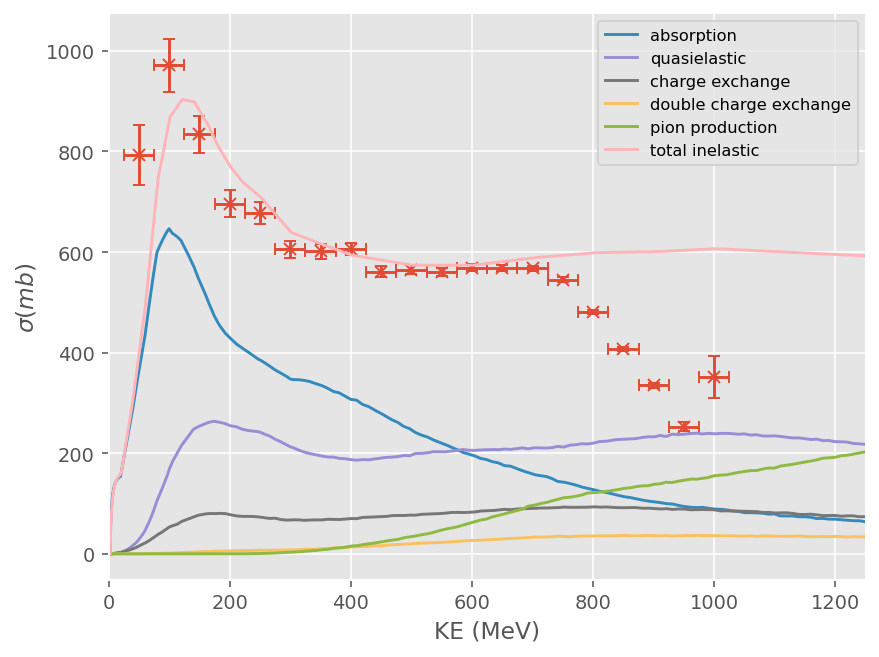

In [98]:
xs = ThinSlice.CrossSection(n_incident, n_interact, energy_slices.width/mean_dEdX)
Plots.Plot(energy_slices.pos[1:-1], xs[0][1:-1], yerr = abs(xs[1])[1:-1], xerr = 25, marker = "x", linestyle = "")
cross_sections.Plot("all")
plt.xlim(0, 1250)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:156: RuntimeWarning: divide by zero encountered in divide
  dEdX = (BetheBloch.rho * BetheBloch.K * BetheBloch.Z * (particle.charge)**2) / (BetheBloch.A * beta**2) * (0.5 * np.log(2 * BetheBloch.me * (gamma**2) * (beta**2) * w_max / (BetheBloch.I**2)) - beta**2 - (BetheBloch.densityCorrection(beta, gamma) / 2))
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:156: RuntimeWarning: divide by zero encountered in log
  dEdX = (BetheBloch.rho * BetheBloch.K * BetheBloch.Z * (particle.charge)**2) / (BetheBloch.A * beta**2) * (0.5 * np.log(2 * BetheBloch.me * (gamma**2) * (beta**2) * w_max / (BetheBloch.I**2)) - beta**2 - (BetheBloch.densityCorrection(beta, gamma) / 2))
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:134: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(beta * gamma)
/home/sb16165/Documents/pi0-analysis/analysis/python/a

[15, 18, 18, 18, 15, 16, 16, 18, 18, 15, ... 15, 18, 17, 18, 16, 18, 19, 16, 18, 16]

[15, 12, 18, 5, 3, 15, 7, 16, 14, 7, 15, ... 13, 16, 17, 14, 10, 16, 18, 13, 17, 14]

[  772  1010  1554  2341  3330  4702  6436  8773 11964 15954 21247 28174
 37399 49285 64102 79839 86243 66854 33245  7780   564   409]

evaluating total_inelastic region

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


evaluating absorption region

evaluating charge_exchange region

evaluating quasielastic region

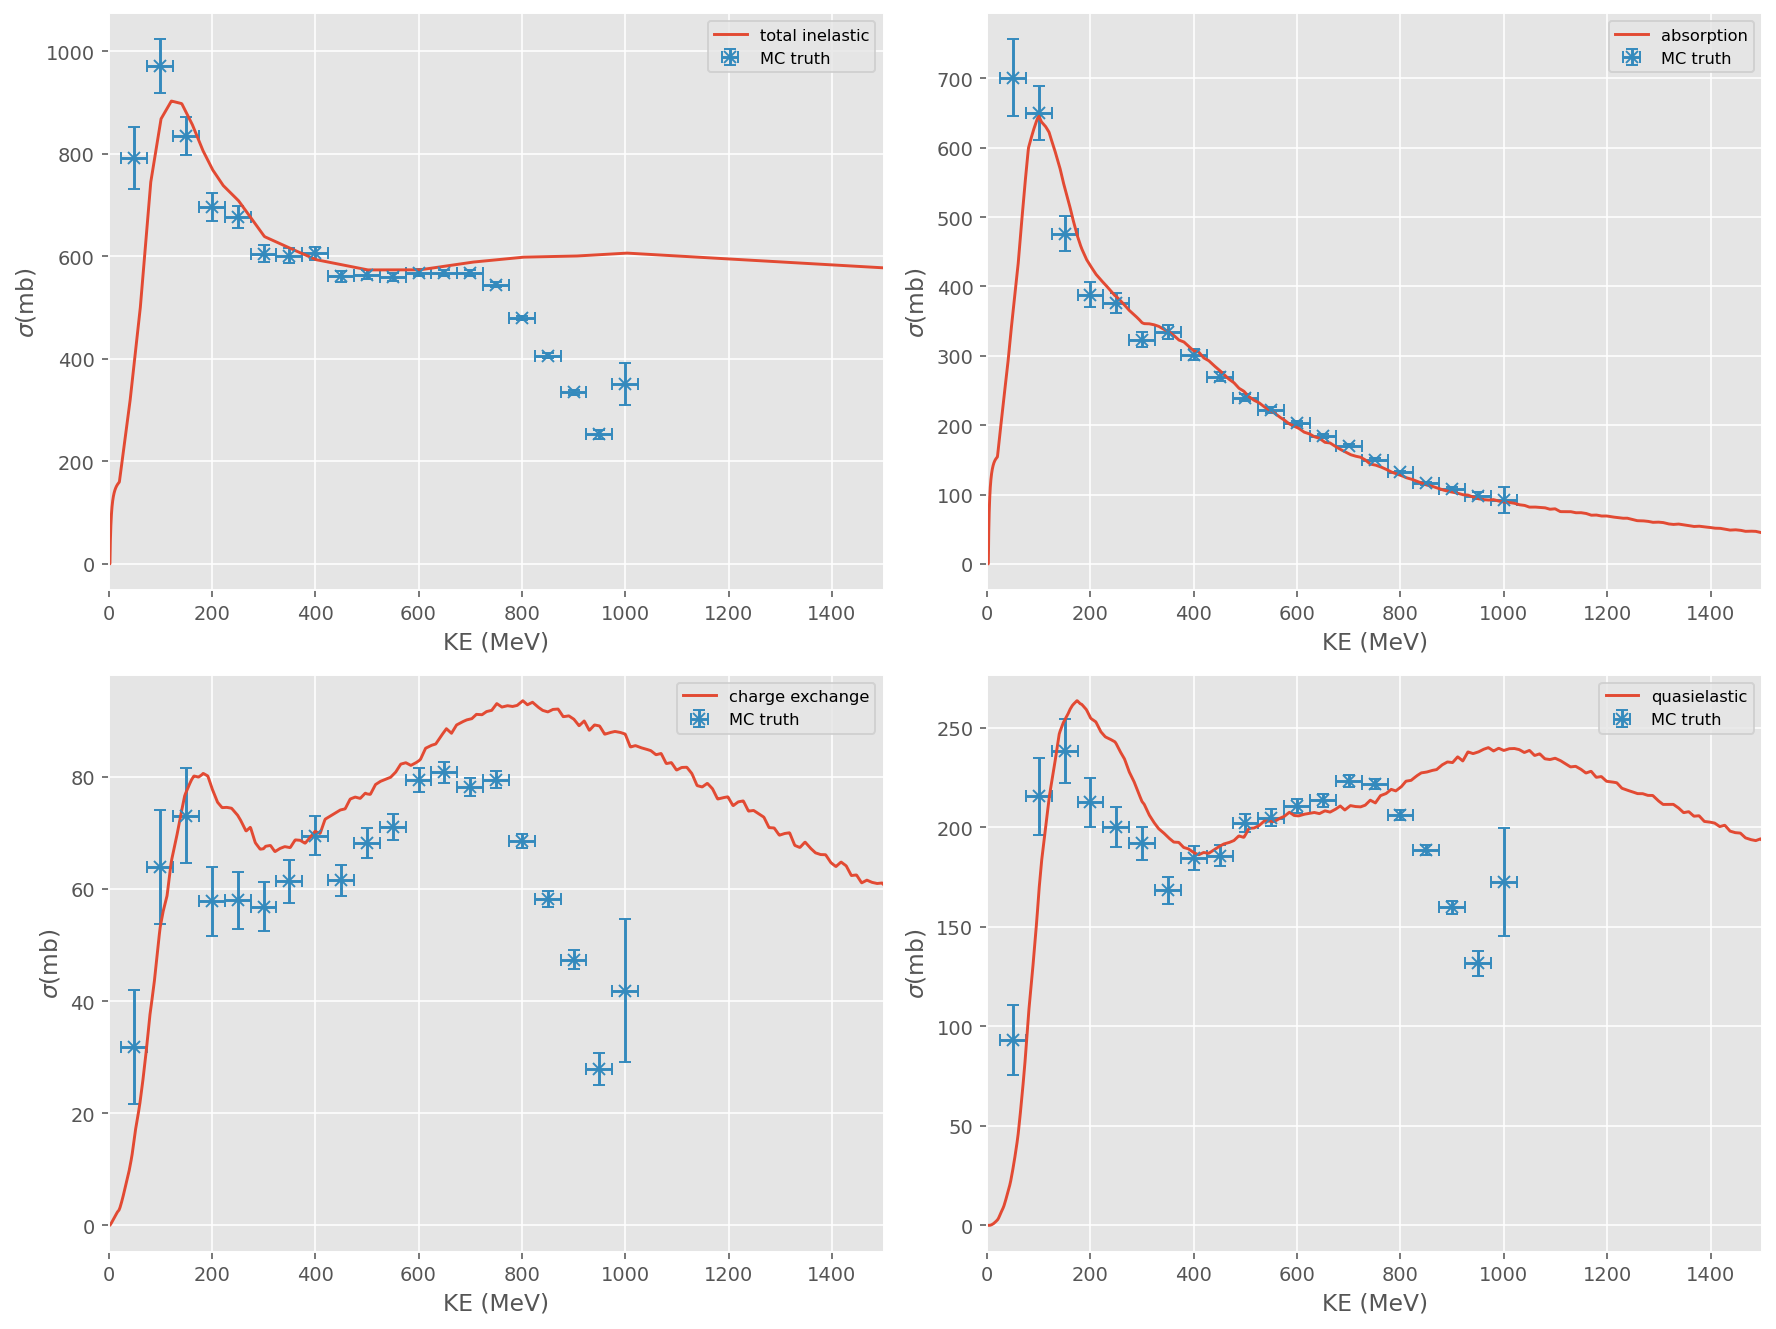

In [102]:
EsliceDemo(events, 50, 1000, 50)

Create thin slices:
 - get all energy depositions made in the collection plane by the beam particle (in Analyser this is view2_IDEs)
 - get the wire pitch in the collection plane (this should be fixed)
 - slice the IDEs by the wire pitch:
   ```c++    
      std::map<int, std::vector<const sim::IDE*>> results; // create a map of slide ID numbers and the ides which fall into this slice

      for (size_t i = 0; i < ides.size(); ++i) {
         int slice_num = std::floor((ides[i]->z - (the_z0 - the_pitch/2.)) / the_pitch); // calculate the slice number for this IDE
         results[slice_num].push_back(ides[i]); // push the IDE into it's relevant slice
   ```
   The formula for calculating the slice number is
   $$
      slice\_num = floor\left(\frac{ide_{z} - z_{0} - \frac{1}{2}pitch}{pitch}\right)
   $$

Create thin tragets:
 - get the initial kinetic energy of the beam particle:
   $$
      KE_{ini} = \sqrt(p^{2} + m^{2}) - m;
   $$
   this is calculated in two ways (for some reason):
   ```c++
     double init_KE = sqrt(1.e6 * true_beam_startP*true_beam_startP +
                        true_beam_mass*true_beam_mass) - true_beam_mass;
   ```
   This uses simb:MCParticle properties
   ```c++
   init_KE = 1.e3 * true_beam_trajectory.E(i-1) - true_beam_mass;
   ```
   This uses the energy in the trajectory point before the first ide in the first slice.
 - loop thorugh all slices
 - calculate the energy deposited in this slice by summing energies of all ides in this slice
 - calculate the incidient energy in this slice, the first incident energy is $KE_{ini}$:
   $$
      KE_{inc, i} = KE_{inc, i-1} - \delta E_{i}
   $$

### Old notes
Create thin slices:
 - get all energy depositions made in the collection plane by the beam particle (in Analyser this is view2_IDEs)
 - get the wire pitch in the collection plane (this should be fixed)
 - slice the IDEs by the wire pitch:
   ```c++    
      std::map<int, std::vector<const sim::IDE*>> results; // create a map of slide ID numbers and the ides which fall into this slice

      for (size_t i = 0; i < ides.size(); ++i) {
         int slice_num = std::floor((ides[i]->z - (the_z0 - the_pitch/2.)) / the_pitch); // calculate the slice number for this IDE
         results[slice_num].push_back(ides[i]); // push the IDE into it's relevant slice
   ```
   The formula for calculating the slice number is
   $$
      slice\_num = floor\left(\frac{ide_{z} - z_{0} - \frac{1}{2}pitch}{pitch}\right)
   $$

Create thin tragets:
 - get the initial kinetic energy of the beam particle:
   $$
      KE_{ini} = \sqrt(p^{2} + m^{2}) - m;
   $$
   this is calculated in two ways (for some reason):
   ```c++
     double init_KE = sqrt(1.e6 * true_beam_startP*true_beam_startP +
                        true_beam_mass*true_beam_mass) - true_beam_mass;
   ```
   This uses simb:MCParticle properties
   ```c++
   init_KE = 1.e3 * true_beam_trajectory.E(i-1) - true_beam_mass;
   ```
   This uses the energy in the trajectory point before the first ide in the first slice.
 - loop thorugh all slices
 - calculate the energy deposited in this slice by summing energies of all ides in this slice
 - calculate the incidient energy in this slice, the first incident energy is $KE_{ini}$:
   $$
      KE_{inc, i} = KE_{inc, i-1} - \delta E_{i}
   $$